In [37]:
# copied from experiment 6 with investigation for lev-mar with quadratic term fitting

In [38]:
import sys
sys.path.insert(0, '../../')

import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from skimage.filters import threshold_li
from gasp import ssfp, phantom, tissue, responses, gasp as GASP

import warnings
warnings.simplefilter('ignore')

In [39]:
def run_gasp(D):

    # Experiment parameters
    T1, T2 = 1.2, .035
    TR, alpha = 5e-3, np.deg2rad(80)
    TE = TR / 2.0
    BetaMax = 4 * np.pi  # usually 2pi, doubled to see multiple bands
    npcs = 16
    pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
    width = 256
    height = 256
    TRs = [5e-3, 10e-3, 15e-3]
    nTRs = len(TRs)

    # Create phantoms, tissues, parameters
    img = phantom.phantom_generator(type='circle')
    t = tissue.tissue_generator(type='circle')
    mask = t['mask']
    size = mask.shape
    t1 = t['t1']
    t2 = t['t2']
    beta = np.linspace(-BetaMax, BetaMax, size[1])
    f = beta / TR / (2 * np.pi)
    f = np.tile(f, (size[0], 1))
    
    # Create simulated phantom data
    M = np.empty((height, width, npcs,  nTRs), dtype=np.complex128)
    for ii, TR in enumerate(TRs):
        TE = TR / 2.0
        M[..., ii] = ssfp.ssfp(t1, t2, TR, TE, alpha, pcs, field_map=f, M0 = mask)

    M = np.reshape(M, (height, width, 1, npcs,  nTRs))
    #print(M.shape)
    
    # Create mask of phantom
    _ = np.sqrt(np.sum(np.abs(M)**2, axis=2))
    _ = np.mean(_, axis=2)
    _ = np.mean(_, axis=2)
    _ = abs(_)
    thresh = threshold_li(_)
    mask = np.abs(_) > thresh
    #print(mask.shape)

    # Apply mask to data
    mask0 = np.tile(
        mask, (M.shape[2:] + (1, 1,))).transpose((3, 4, 0, 1, 2))
    data = M * mask0
    #print(data.shape)
    
    # Reshape data to required shapes
    data = np.reshape(data, data.shape[:-2] + (-1,))    # [Height, Width, Coil, PCs x TRs]
    data = np.moveaxis(data, 2, 0)                      # [Coil, Height, Width, PCs x TRs]
    data = data.transpose((0, 3, 1, 2))                 # [Coil,  PCs x TRs, Width, Height]
    #print(data.shape)

    # Get new dimensions
    ncoils, npcs, height, width = data.shape[:]

    # Calibration box - (# Number of lines of calibration, Pixels on signal)
    C_dim = (32, width)
    
    # Run gasp
    Ic = np.zeros((ncoils, height, width), dtype='complex')
    for cc in range(ncoils):
        Ic[cc, ...] = GASP.gasp(data[cc, ...], D, C_dim, pc_dim=0, method='lev-mar-quad')  # compare to 'linear'
    Ic_phase = np.angle(Ic[0, ...])
    Ic = np.sqrt(np.sum(np.abs(Ic)**2, axis=0))
    
    # Plot data
    _ = np.sqrt(np.sum(abs(data[:, 0, ...])**2, axis=0))
    phase = np.angle(data[0, 0, ...])

    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(141)
    ax2 = f.add_subplot(142)
    ax3 = f.add_subplot(143)
    ax4 = f.add_subplot(144)

    ax.imshow(_, cmap='gray')
    ax2.plot(_[int(width/2), :])
    ax2.plot(phase[width // 2, :])
    ax3.imshow(Ic, cmap='gray')
    ax4.plot(np.abs(Ic[int(height/2), :]), label='Simulated Profile')
    ax4.plot(Ic_phase[height // 2, :], label='Simulated Profile Phase')
    ax4.plot(np.abs(D), '--', label='Desired Profile')
    ax4.plot(np.angle(D), ':', label='Desired Profile Phase')
    ax4.legend()

    plt.show()

    residual = Ic[height // 2, :] - D
    print(np.sqrt(np.sum(np.abs(residual)**2)))


In [40]:
width = 256
height = 256

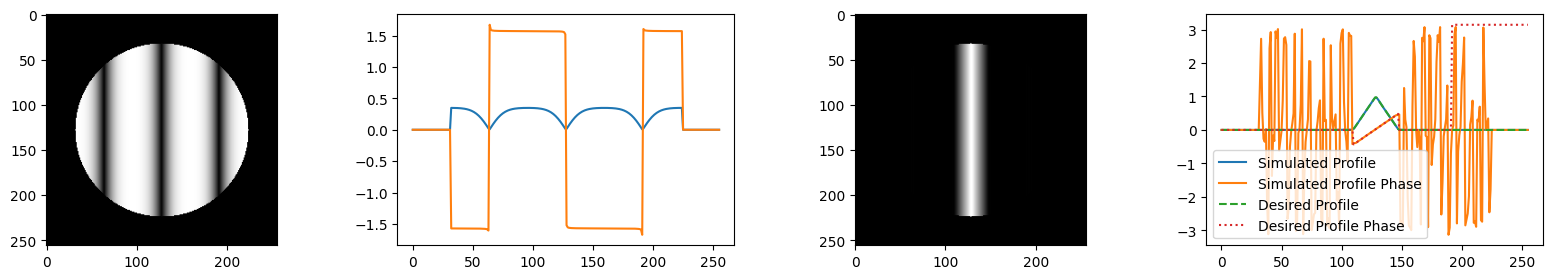

0.5338974528745629


In [41]:
D = responses.triangle_periodic(width, 1000, 110, 38)
D = D*np.exp(1j*np.linspace(-np.pi, np.pi, width))
run_gasp(D)

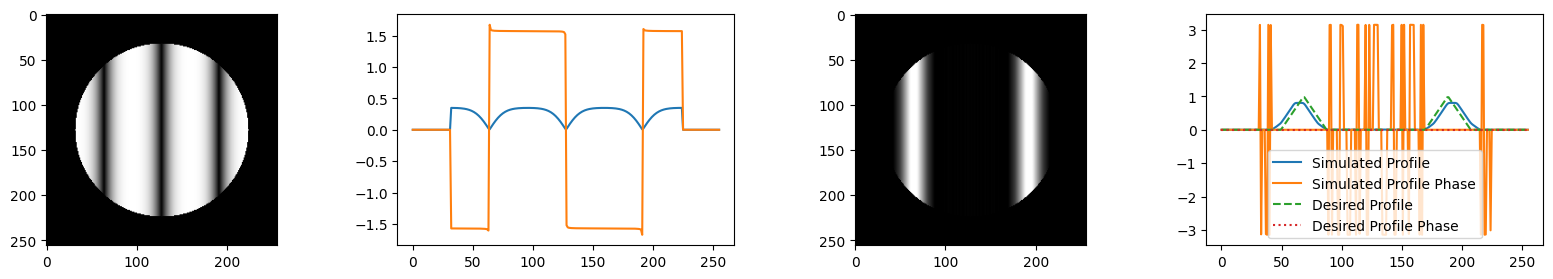

1.5405050207129531


In [42]:
D = responses.triangle_periodic(width, 120, 50, 38)
run_gasp(D)

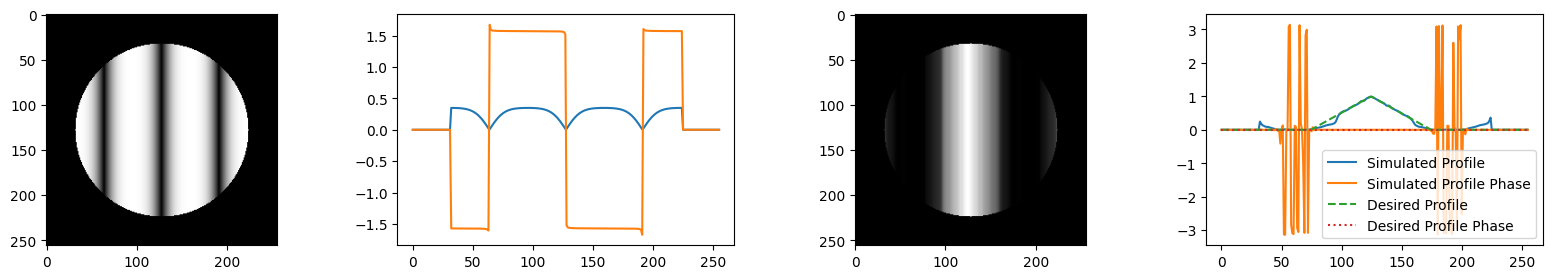

1.0415115047656085


In [43]:
D = responses.triangle_periodic(width, 1000, 75, 100)
run_gasp(D)

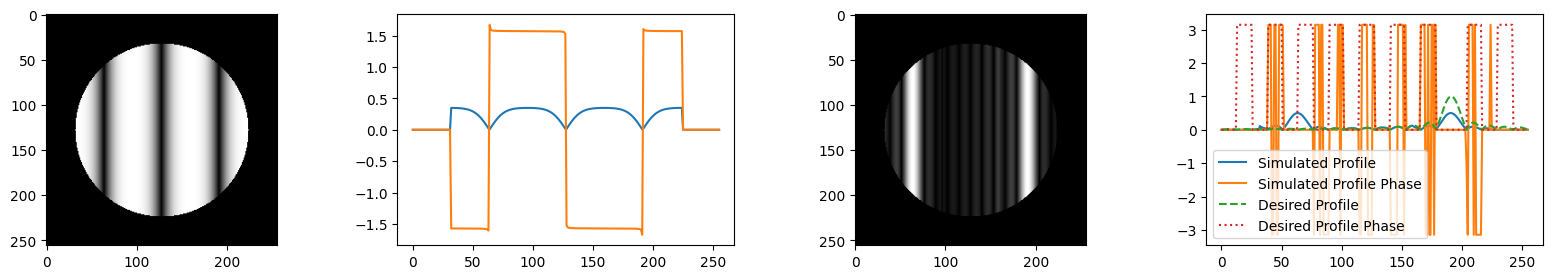

2.7926411955121067


In [44]:
bw = 0.1
shift = 0.5
D = responses.sinc(width, bw, shift)
run_gasp(D)

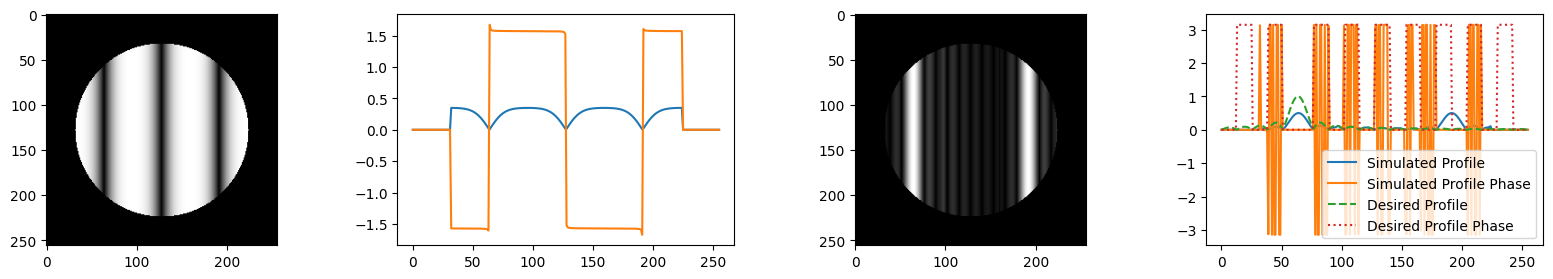

2.7949946175640425


In [45]:
bw = 0.1
shift = -0.5
D = responses.sinc(width, bw, shift)
run_gasp(D)

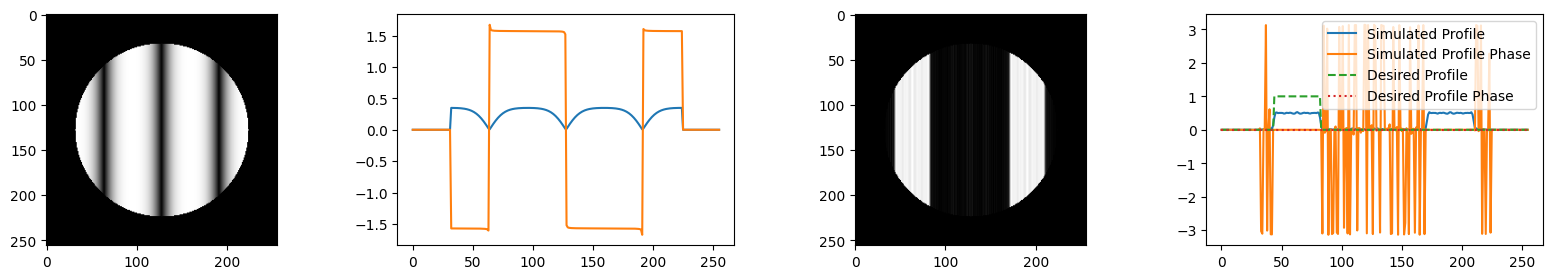

4.438586588194612


In [46]:
bw = 0.15
shift = -0.25
D = responses.square(width, bw, shift)
run_gasp(D)

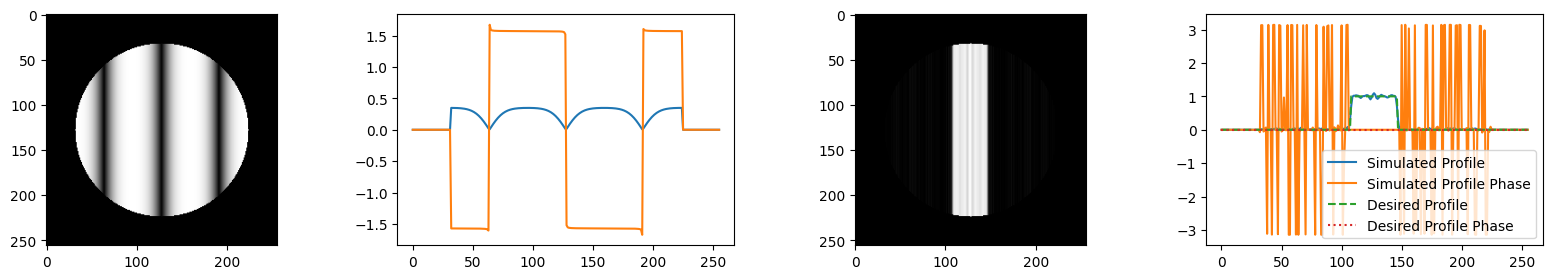

0.6846209650775081


In [47]:
bw = 0.15
shift = 0
D = responses.square(width, bw, shift)
run_gasp(D)

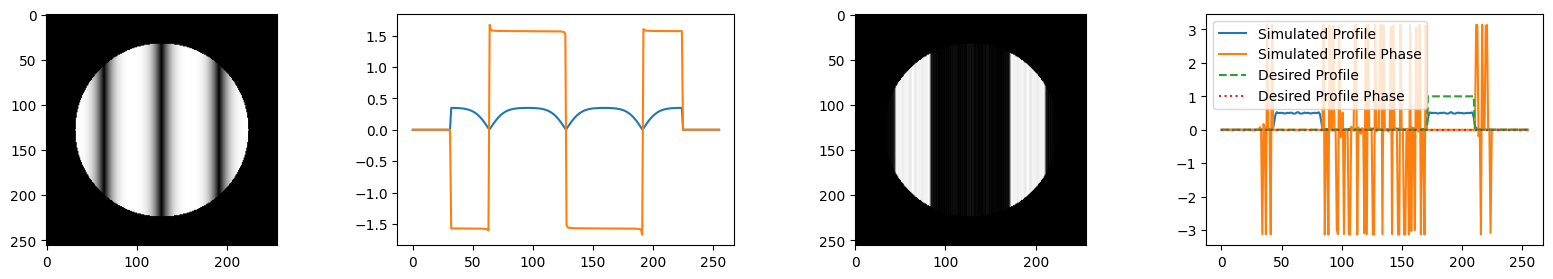

4.437928300348341


In [48]:
bw = 0.15
shift = 0.25
D = responses.square(width, bw, shift)
run_gasp(D)